## Import & Load

In [221]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import zscore
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

data = pd.read_csv('oecd_data.csv')
data.head()

,TIME_PERIOD,REF_AREA,Reference_area,MEASURE,OBS_VALUE
0,2022-01-01,ESP,Spain,PRVM,-0.484027
1,2022-02-01,ESP,Spain,PRVM,-0.583658
2,2022-03-01,ESP,Spain,PRVM,-3.620352
3,2006-06-01,AUT,Austria,PRVM,89.532692
4,2006-05-01,AUT,Austria,PRVM,88.461157


### OECD Measure Codes

| **Code**     | **Name**                                 | **Explanation**                        |
|--------------|------------------------------------------|----------------------------------------|
| `UNE_LF_M`   | Unemployment, Labour Force, Monthly      | % jobless in labor force      |
| `BCICP`      | Business Confidence Indicator, Composite | Business sentiment >100 = optimism     |
| `CPI`        | Consumer Price Index                     | Inflation measure |
| `GGD`        | General Government Debt                  | Government debt as % of GDP            |
| `CCICP`      | Consumer Confidence Indicator, Composite | Consumer outlook >100 = confidence     |
| `GDPG`       | GDP Growth                               | Economic growth rate (% change)        |
| `PRVM`       | Production Volume                        | Industrial Production. Change in volume |
| `LI`         | Composite Leading Indicator              | Predicts future economic momentum      |
| `GDP`        | Gross Domestic Product                   | Total economic output                  |


In [210]:
measure_dict = {
    "UNE_LF_M": "Unemployment Rate",
    "BCICP": "Business Confidence",
    "CPI": "Consumer Price Index",
    "GGD": "Government Debt",
    "CCICP": "Consumer Confidence",
    "GDPG": "GDP Growth",
    "PRVM": "Production Volume",
    "LI": "Composite Leading Indicator",
    "GDP": "Gross Domestic Product"
}
data['Measure_Desc'] = data['MEASURE'].map(measure_dict)

## Summary Stats

In [222]:
summary = data.groupby('MEASURE')['OBS_VALUE'].describe()
display(summary)

,count,mean,std,min,25%,50%,75%,max
MEASURE,,,,,,,,
BCICP,10571.0,100.053985,2.113314,83.172550,99.030995,100.244000,101.337800,106.949700
CCICP,9374.0,99.802908,2.198668,89.346620,98.461520,99.990995,101.272675,107.727600
CPI,20764.0,53.878492,59.588958,-6.508876,2.477990,45.906710,100.300000,1185.694000
GDP,722.0,43174.896136,21046.409498,9433.241822,28807.479316,40646.358029,51626.168132,145507.119829
GDPG,3236.0,0.554138,2.220610,-22.667100,0.067117,0.601778,1.230934,22.376300
GGD,690.0,74.342049,43.258505,7.301000,43.459000,63.850500,98.212250,246.616000
LI,3961.0,99.983112,1.381792,75.715920,99.470850,100.109000,100.696900,104.803000
PRVM,25531.0,35.366034,49.300077,-57.278604,-0.279590,2.973662,95.653699,217.221584
UNE_LF_M,8907.0,7.523534,3.981328,1.700000,4.800000,6.700000,9.100000,28.300000


The summary stats for the indicators within the OECD dataset show the means for BCI, CCI and CLI aarount 100 which is expected as < 100 means pessimism and > 100 means optimism in those indicators.

The GDP indicator has a large standard deviation which suggests the size of the economies in the dataset is widely varied.

In terms of data quality checking the min and max values of the indicators there is not serious outliers that would indicate errors that I can see.

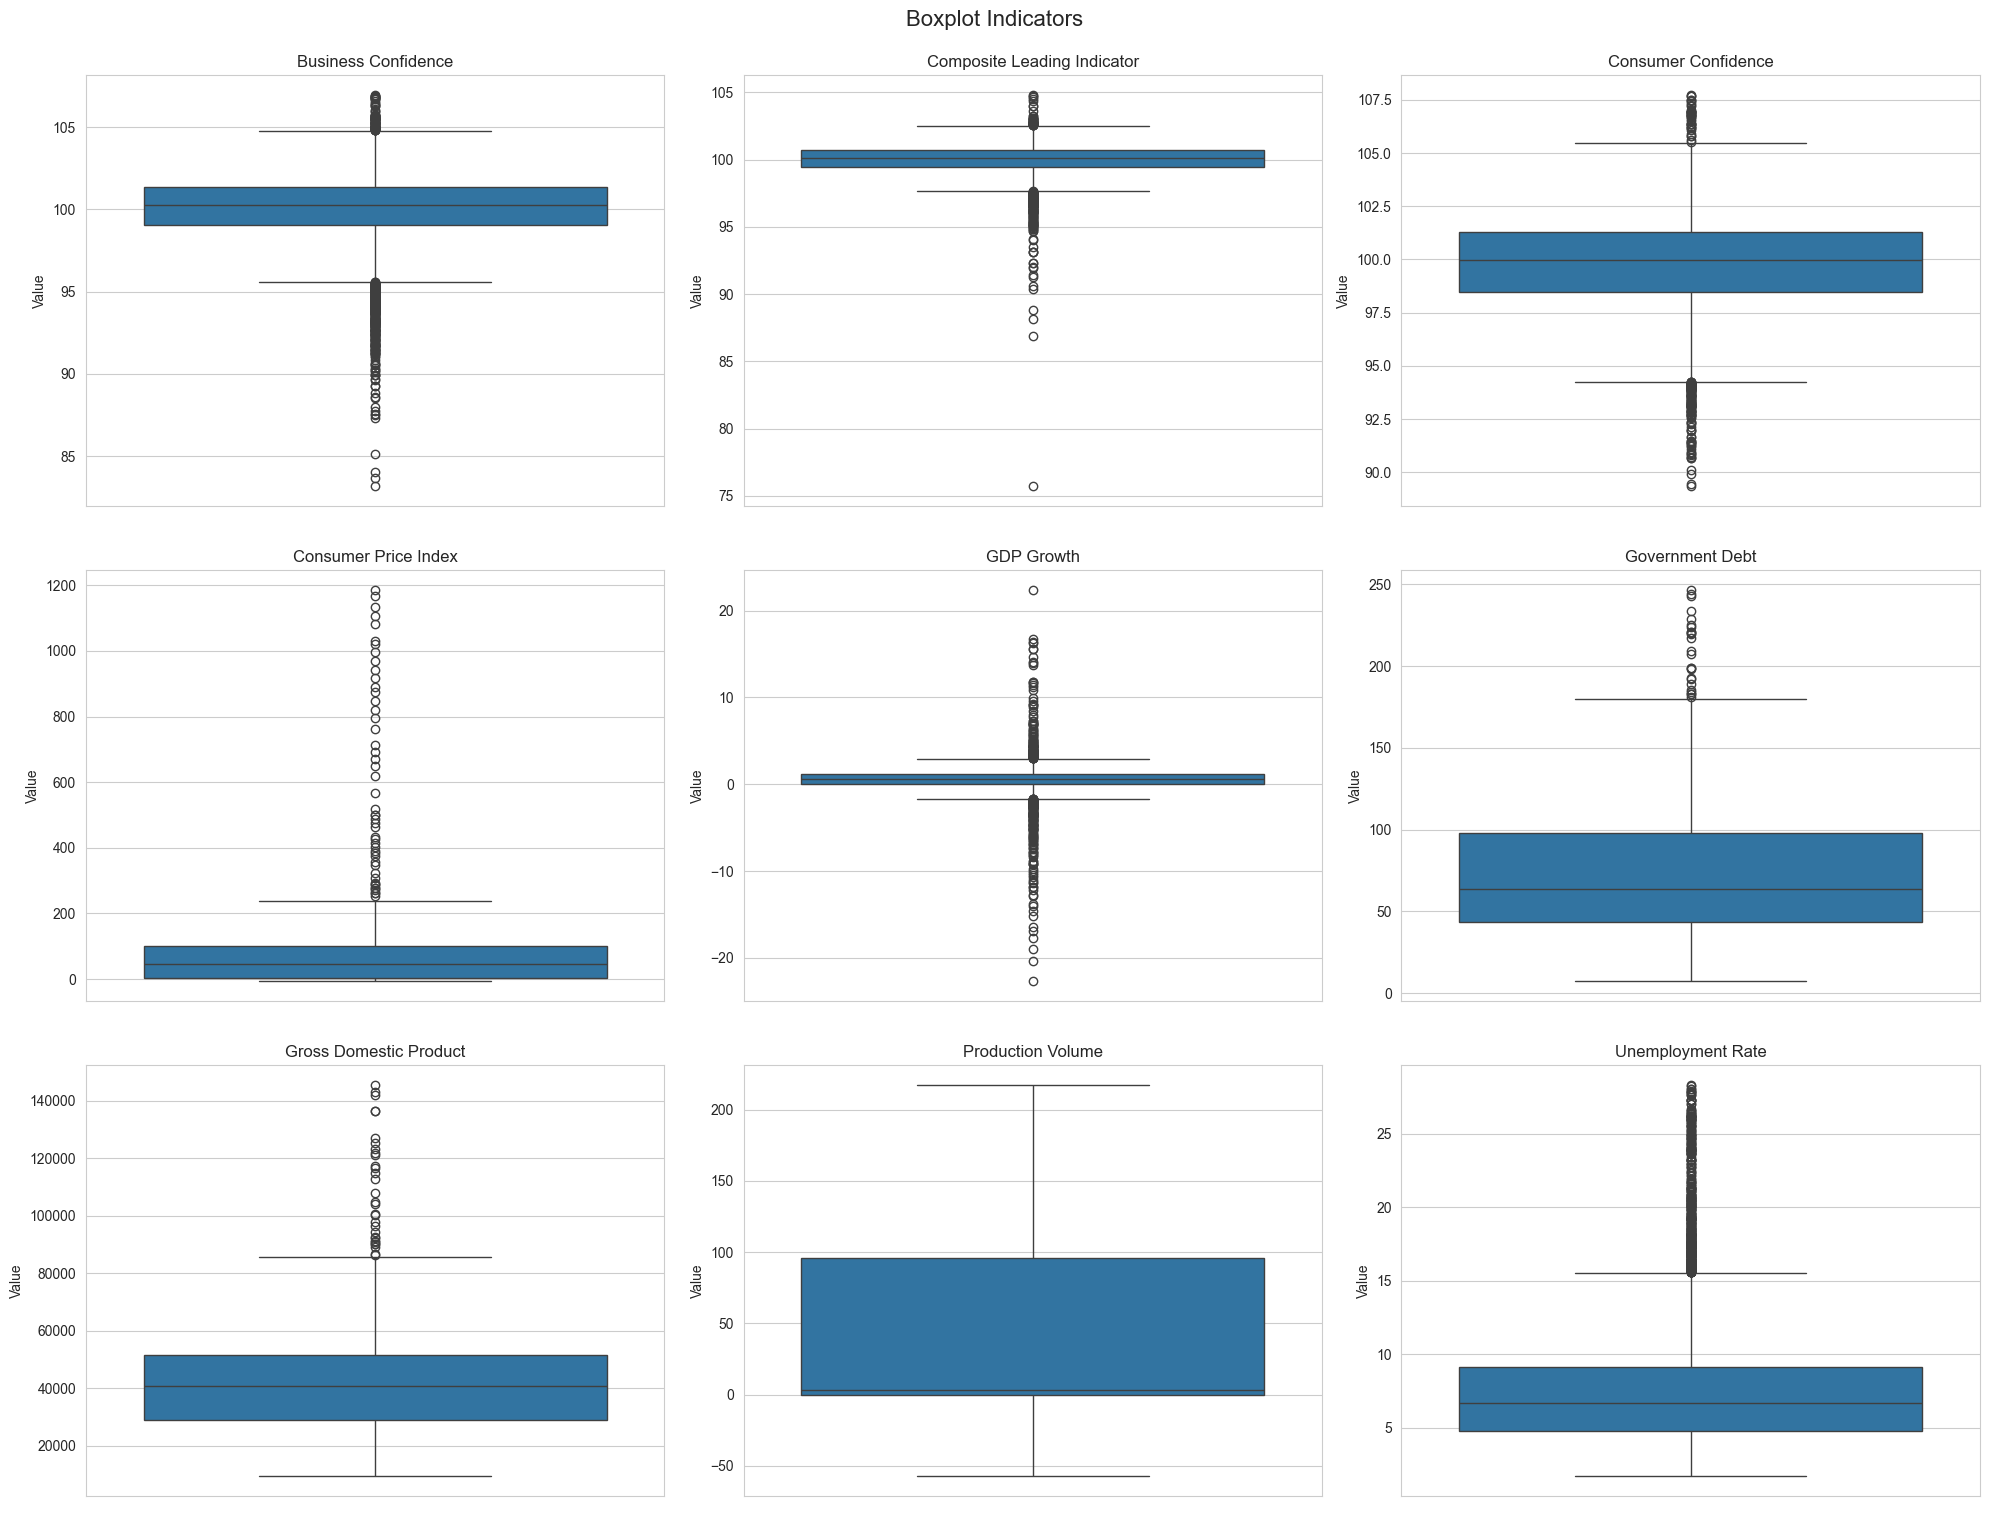

In [212]:
measures = data['Measure_Desc'].unique()
measures.sort()

fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()

for i, measure in enumerate(measures):
    ax = axes[i]
    subset = data[data['Measure_Desc'] == measure]
    sns.boxplot(data=subset, y='OBS_VALUE', ax=ax)
    ax.set_title(measure)
    ax.set_xlabel(' ')
    ax.set_ylabel('Value')

plt.tight_layout()
plt.suptitle("Boxplot Indicators", fontsize=16, y=1.02)
plt.show()

The boxplots above show:

- **BCI**: Median is centered around 100 and IQR only varies a couple of points either side of 100. Suggesting stability for this indicator for most OECD countries. This is further confirmed by the whiskers of the boxplot only extending to range of roughly 95 to 105. Outside of this there are outliers and more so in the negative direction.
- **CLI**: Median is also centred around 100 and the IQR is even more tightly centred than BCI. The whiskers also only extend to a couple of points wither side to 100. This suggests extreme stability in this indicator for the OECD countries.
- **CCI**: This indicator has a slightly wider spread than BCI and CLI. The median is still centred around 100 as expected but the IQR is larger and the whiskers also extend slightly further.
- **CPI**: This is a highly skewed indicator. Most values are low with a mean of roughly 53 but there are extreme outliers on the high end up to 1200. This suggest that there are some countries with extremely high inflation rates within the OECD country list.
- **GDP Growth**: This indicator is tightly centred around 0 which is reasonable as that is neither growth or decline. Suggesting most countries stability with inflation. But there are extreme outliers in both directions, showing that some countries are exeriencing either large growth or decline in GDP.
- **Gov Debt**: Wide variation across the data, with a median of about 70% of GDP, and an IQR between 45% and 100% of GDP. But there is some slight skew on the high end suggesting there are manu countries with a high debt vs GDP above 100%.
- **GDP**: Median around 40,000 but high variation with the whiskers ranging from what appears to be 10,000 upto 90,000 and lots of outliers on the high end up to 140,000+. Countries with a high GDP may be skewing this indicator.
- **Prod Volume**: Not entirely certain what to make of this boxplot. Median is around 0 meaning no change in production volume from industry. The IQR is ranging from 0 to 100 with the whiskers going in both negative and positive directions. I believe this indicates that most countries in the OECD dataset are either maintaining or slowly growing industiral production volume.
- **Unemployment**: MOst countries in the OECD seem to have unemployment rates under 10% but there are quiote a number of outlier countries with a higher unemployment rate ranging up to roughly 25%.

## Index Based Indicators Over Time

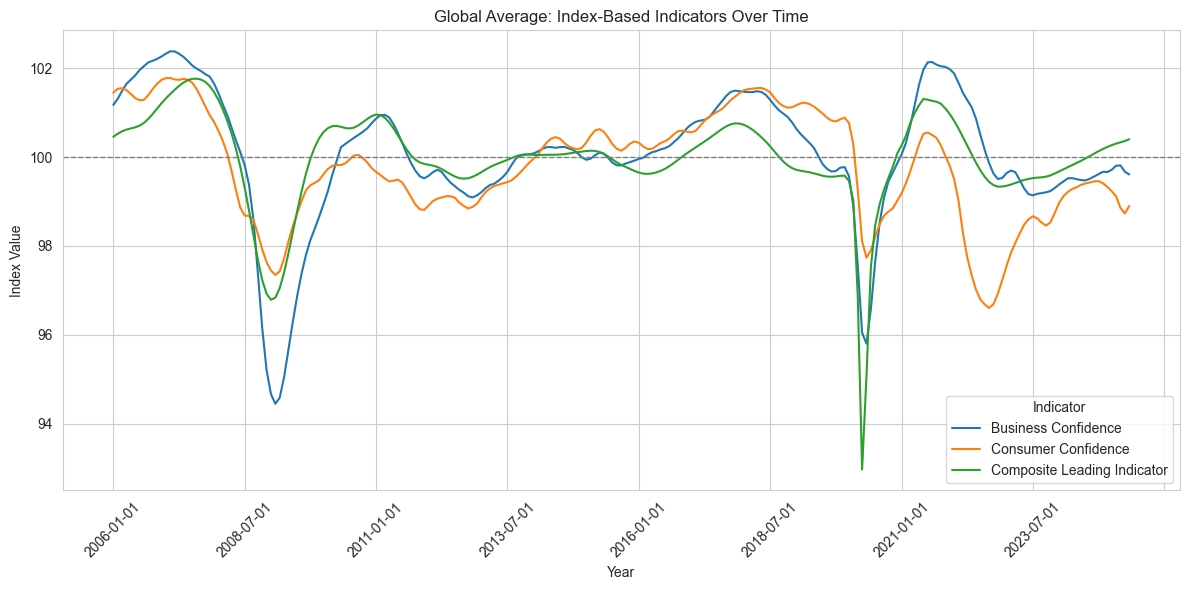

In [213]:
avg = data.groupby(['TIME_PERIOD', 'Measure_Desc'])['OBS_VALUE'].mean().reset_index()

index_indicators = {'Business Confidence', 'Consumer Confidence', 'Composite Leading Indicator'}
other_indicators = [i for i in avg['Measure_Desc'].unique() if i not in index_indicators]

plt.figure(figsize=(12, 6))
for indicator in index_indicators:
    sns.lineplot(data=avg[avg['Measure_Desc'] == indicator], x='TIME_PERIOD', y='OBS_VALUE', label=indicator)
plt.axhline(100, linestyle='--', color='gray', linewidth=1)
plt.title("Global Average: Index-Based Indicators Over Time")
plt.xlabel("Year")
plt.ylabel("Index Value")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.legend(title="Indicator")
plt.tight_layout()
plt.show()


The chart over combines the Global averages for CLI (Composite Leading Indicator), BCI (Business Confidence Index), CCI (Consumer Confidence Index) together over time. This is because all 3 are normalised around 100 and therefore have the same logic for both the X axis of time, and the Y axis of index score. Meaning they can be compared together over time to understand the overall trends in these indicators.

A horizontal line has been placed at 100 on the Y-Axis as this determines when the indicators go from Pessimism to Optimism as explained earlier.

It can be seen in the graph that the 3 indicators are related and when there are serious shocks to the economy such as the 2008 financial crash, or the 2020 COVID 19 pandemic, all 3 indicators see a sharp drop below 100 to the lowest points around 95 since 2006.

- **BCI**: Shows that business confidence is overall more volatile to shocks in the economy compared with consumers as it drops lower when trouble occurs but also climbs faster and reaches higher peaks when bouncing back. This may be a result of investment within business causing risks in the financial markets to be more acutely felt in both negative and positive conditions.
- **CCI**: Seems less volatile overall as it doesn't drop or rise to the same extremes as BCI, but consumers appear to be more cautious as for the majority of the graph the CCI spends more time below the BCI and also more time below 100. Meaning consumers are generally more pessimistic about the economy.
- **CLI**: Is designed to show early signal signs in business cycles and economic activity. Showing whether markets are switching betwen bullish and bearish market periods (growth and expansion, vs slowdown and shrinking respectively). The end of the graph has an uptick above 100 which is hopefully suggestive of economic recovery in the near future.

## Other Indicator Global Averages over Time

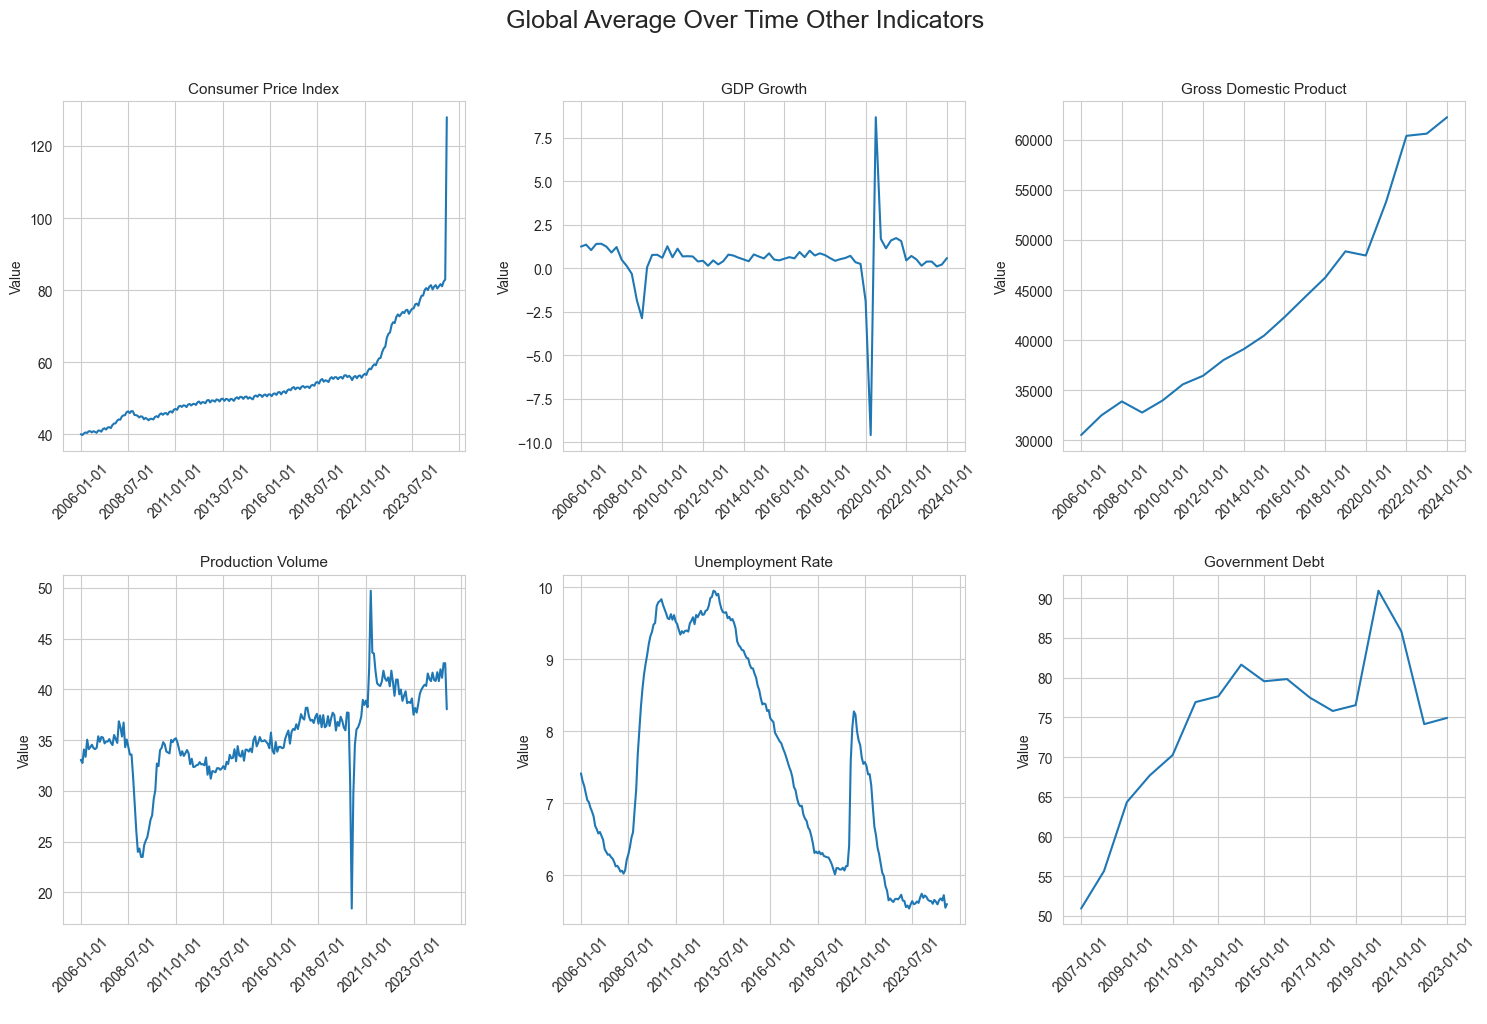

In [214]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, indicator in enumerate(other_indicators):
    ax = axes[i]
    subset = avg[avg['Measure_Desc'] == indicator]
    sns.lineplot(data=subset, x='TIME_PERIOD', y='OBS_VALUE', ax=ax)
    ax.set_title(indicator, fontsize=11)
    ax.set_xlabel(' ')
    ax.set_ylabel('Value')
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.tick_params(axis='x', rotation=45)

plt.suptitle("Global Average Over Time Other Indicators", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

- **CPI/Inflation**: Since 2006 there has been a steady rise in inflation from 40 to over 120, with a sharp and dramatic increase since 2021. Likely driven by COVID and matches what we see in the world with inflation increasing.
- **GDP Growth**: Relatively stable with the average for the dataset hovering just above 0% which is reasonable with the exception of 2020 where there was a sharp decrease and then increase again around COVID.
- **GDP**: Strong growth over time indicating the OECD countries on average are growing their GDP over time and shows the economies within the OECD country set are growing.
- **Production Volume**: Similar to GDP growth this is relatively stable with a slow increase over time within the OECD countries, the only notable differecnes are around the 2008 economic crisis and 2020 COVID pandemic.
- **Unemployment**: Sharp increase after 2008 financial crisis, but recovered from the high of 10% average from 2013 down to 6% average in 2018. Another spike in 2020 from COVID upto 8%, but this is recovering again quickly down to less than 6% in 2022 and remains stable since up to latest date.
- **Gov Debt**: Similar to the other charts the debt for governments increased since 2007 and peaked during COVID. It was dropping after covid as economies bounced back but the last data point is an uptick in 2023.

## Top 5 Upward and Downward Trending Countries by Indicator

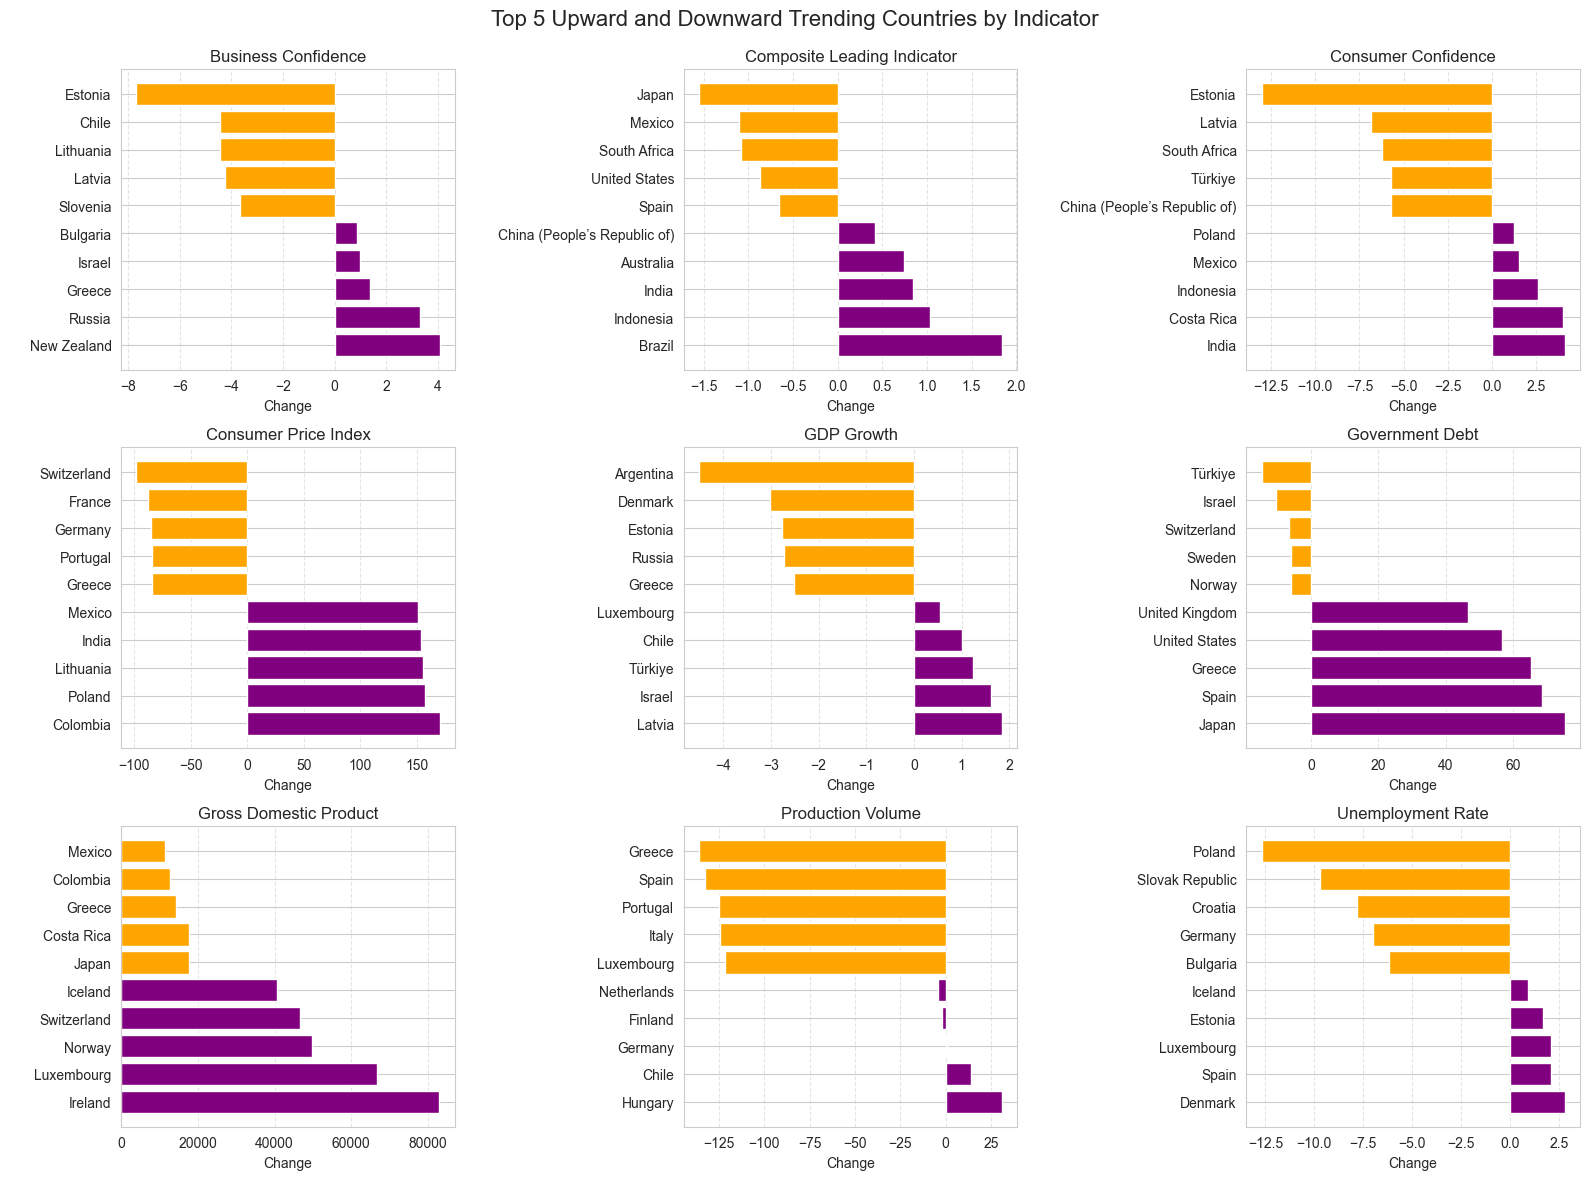

In [215]:
def get_trending_countries(data, indicator, time_col='TIME_PERIOD', country_col='Reference_area', value_col='OBS_VALUE'):
    df = data[data['Measure_Desc'] == indicator].copy()

    df[time_col] = pd.to_datetime(df[time_col])
    df = df.sort_values([country_col, time_col])

    first = df.groupby(country_col).first()[value_col]
    last = df.groupby(country_col).last()[value_col]

    change = (last - first).sort_values(ascending=False)
    return change

def get_top_changes(indicator, ax):
    change = get_trending_countries(data, indicator)

    top_5_upward = change.head(5)
    top_5_downward = change.tail(5)

    top_changes = pd.concat([top_5_upward, top_5_downward])
    colors = ['orange' if y in top_5_downward else 'purple' for y in top_changes.index]
    ax.barh(top_changes.index, top_changes.values, color=colors)
    ax.set_title(indicator)
    ax.set_xlabel("Change")
    ax.set_ylabel(" ")
    ax.grid(axis='x', linestyle='--', alpha=0.5)

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()
for j, measure in enumerate(measures):
    ax = axes[j]
    get_top_changes(measure, ax)
fig.suptitle("Top 5 Upward and Downward Trending Countries by Indicator", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


The functions used to create these graphs takes the first value from 2006 for each indicator and the lastest value for each indicator. It then calculates the change between then and now to identify over the last 20 years or so which countries have seen the largest changes in either direction for each indicator. To quickly suggest countries who are experiencing an overall trend in value for each indicator over 2 decades to find those examples where confidence, debt or unemployment is trending in a direction over longer periods of time regardless of any micro direction changes year by year.


- **BCI**: Baltic countries such as Estonia, Latvia and Lithuania were amoungst the worst affected in business confidence over time. Whereas, Isreal, Greece, Russia and New Zealand all saw the highest overall change in BCI.
- **CLI**: Japan, Mexico, South Africa, USA, and Spain are all trending downwards over the last 20 years, indicating a potential for future slowdown. Whereas, China, Australia, India, Indonesia, and Brazil are the strongest countries trending upwards, suggesting optimism for the future and growth particularly in the APAC region.
- **CCI**: Baltic countries such as Estonia and Latvia saw the largest trend downwards here too as well as BCI. Whereas, Mexico, Indonesia, and India where amoungst the top trending upwards for CCI as well as CLI suggesting there is impriving outlooks for consumers in the APAC region.
- **CPI/Inflation**: European countries such as Switzerland, France, Germany, Portugal, and Greece saw the best decline inflation over 20 years. Countries such as Mexico, India, Lithuania, Poland, and Columbia saw the highest overall change in inflation.
- **GDP Growth** and **Gov Debt**: Countries such as Turkey and Isreal show the best overall change in GDP growth and the biggest negative change in government debt suggesting that these 2 indicators are related and that as GDP growth increases it outpaces the debt governments accrue. Whereas, countries such as greece saw a large slowdown of GDP growth and an increase in governemtn debt further suggesting that relationship over time.
- **GDP**: European countries seem to have saw the largest change in GDP ranging from a 40,000 to 80,000 increase. Japan and Mexico saw some of the least overall changes in GDP which aligns with the overall trends downwards in CLI indicators suggesting a relationship there too.
- **Production Volume**: Even to of the highest changes in production are still negative suggesting an overall trend in deindustrialisation amoungst the data points for the indicator.
- **Unemployment**: The highest change in an upward direction for unemployment is only 2.5% for Denmark where as the biggest change overall in a downward direction os Poland at 12.5%. This is encouraging as it shows that the OECD countries on the whole see larger overall changes in a good way for unemployment.

## Indicator Missingness

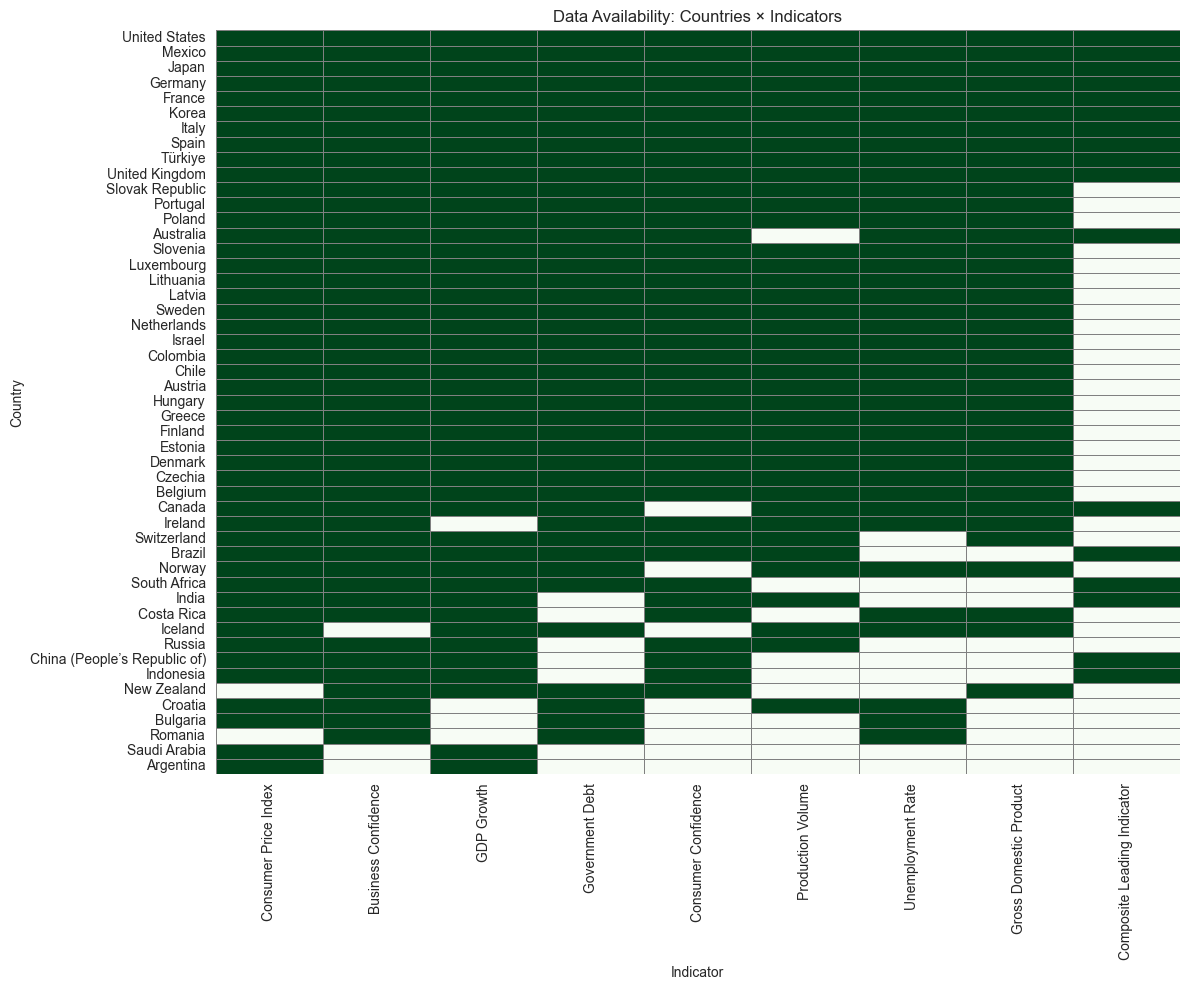

In [216]:
presence = data.pivot_table(index='Reference_area', columns='Measure_Desc', values='OBS_VALUE', aggfunc='count')
presence = presence.notna().astype(int)
sorted_cols = presence.sum().sort_values(ascending=False).index
presence_sorted = presence[sorted_cols]
sorted_rows = presence_sorted.sum(axis=1).sort_values(ascending=False).index
presence_sorted = presence_sorted.loc[sorted_rows]

plt.figure(figsize=(12, 10))
sns.heatmap(presence_sorted, cmap='Greens', cbar=False, linewidths=0.5, linecolor='gray')
plt.title("Data Availability: Countries × Indicators")
plt.xlabel("Indicator")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

The CLI indicators has many missing data points and is by far the indicator with the most missing data. THe rest have broad coverage but there are no indicators with full coverage of every country. Below is a list of the countries with values for all indicators except CLI and can be seen there is 30 countries.

In [217]:
filtered_data = data[data['Measure_Desc'] != 'Composite Leading Indicator']
pivot = filtered_data.pivot_table(index=['TIME_PERIOD', 'Reference_area'], columns='Measure_Desc', values='OBS_VALUE').dropna()
countries = pivot.index.get_level_values('Reference_area').unique()
print(f"Available countries: {len(countries)}\n{countries.tolist()}")

Available countries: 30
['Austria', 'Belgium', 'Chile', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Italy', 'Japan', 'Korea', 'Latvia', 'Lithuania', 'Luxembourg', 'Mexico', 'Netherlands', 'Poland', 'Portugal', 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden', 'United Kingdom', 'United States', 'Türkiye', 'Israel', 'Colombia']


## Indicator Correlations

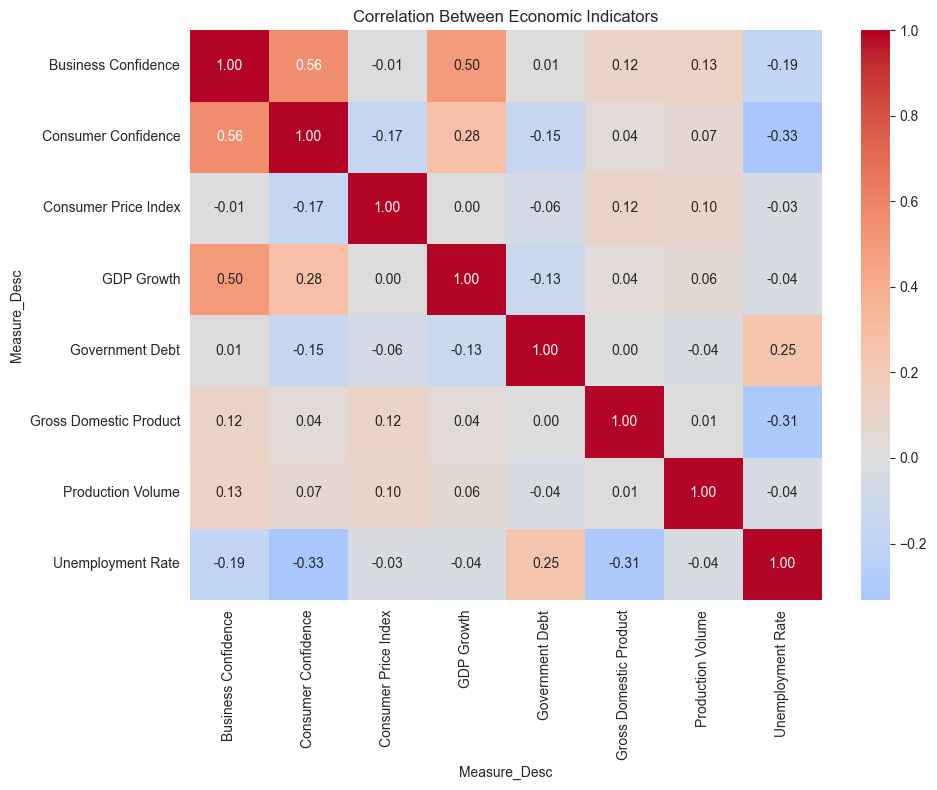

In [218]:
correlation_matrix = pivot.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation Between Economic Indicators")
plt.tight_layout()
plt.show()

There seems to be a moderate correlation between the following indicators:
- GDP Growth and Business Confidence
- Business Confidence and Consumer Confidence
- Consumer Confidence and Unemployment (negative)
- GDP and Unemployment (Negative)

## Country Clustering

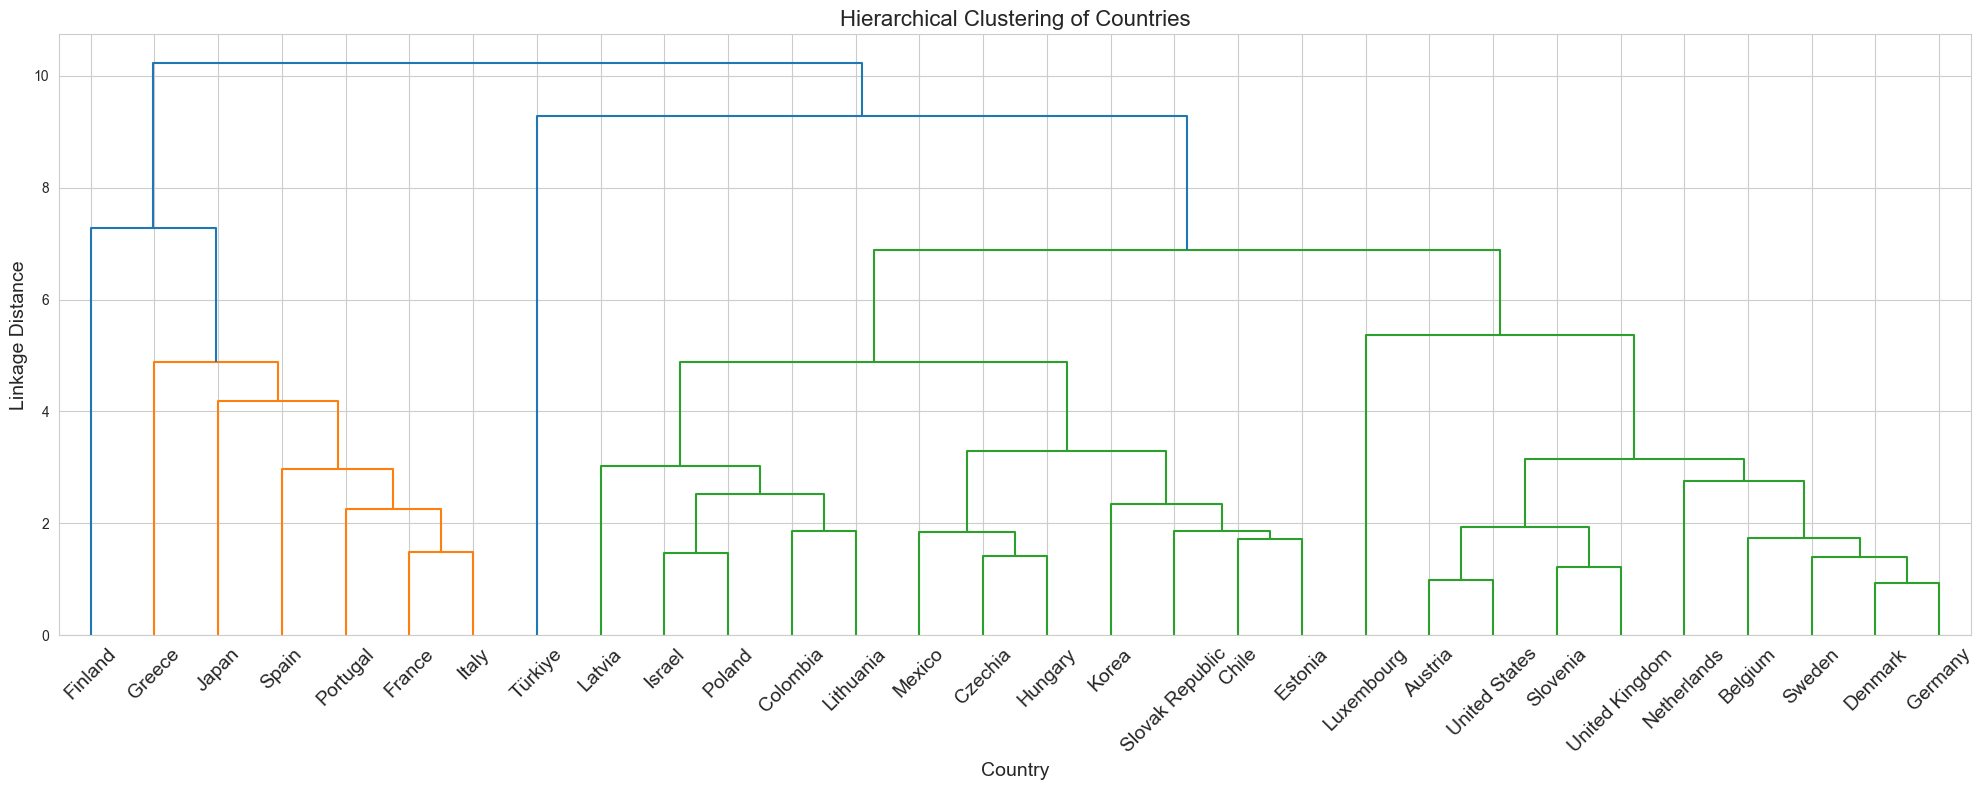

In [219]:
pivot_cluster = filtered_data.pivot_table(index='Reference_area', columns='Measure_Desc', values='OBS_VALUE', aggfunc='mean').dropna()
x_scaled = pivot_cluster.apply(zscore)
Z = linkage(x_scaled, method='ward')
plt.figure(figsize=(20, 8))
dendrogram(Z, labels=pivot_cluster.index.tolist(), leaf_rotation=45, leaf_font_size=14)
plt.title("Hierarchical Clustering of Countries", fontsize=16)
plt.xlabel("Country", fontsize=14)
plt.ylabel("Linkage Distance", fontsize=14)
plt.tight_layout()
plt.show()


In [226]:
pivot_cluster['Cluster'] = fcluster(Z, t=5, criterion='maxclust')
for cluster_id, group in pivot_cluster.groupby('Cluster'):
    print(f"\nCluster {cluster_id}")
    print(group.index.tolist())
print("\n")
cluster_profiles = pivot_cluster.groupby('Cluster').mean()
cluster_profiles_t = cluster_profiles.round(2).T
cluster_profiles_t


Cluster 1
['France', 'Greece', 'Italy', 'Japan', 'Portugal', 'Spain']

Cluster 2
['Finland']

Cluster 3
['Chile', 'Colombia', 'Czechia', 'Estonia', 'Hungary', 'Israel', 'Korea', 'Latvia', 'Lithuania', 'Mexico', 'Poland', 'Slovak Republic']

Cluster 4
['Austria', 'Belgium', 'Denmark', 'Germany', 'Luxembourg', 'Netherlands', 'Slovenia', 'Sweden', 'United Kingdom', 'United States']

Cluster 5
['Türkiye']




Cluster,1,2,3,4,5
Measure_Desc,,,,,
Business Confidence,99.95,99.64,100.05,100.21,98.94
Consumer Confidence,98.93,99.45,100.18,99.80,99.41
Consumer Price Index,51.33,51.47,54.12,52.51,111.65
GDP Growth,0.14,0.18,0.65,0.39,1.25
Government Debt,144.50,69.57,51.09,76.55,37.20
Gross Domestic Product,37939.64,46575.22,29427.10,56300.11,25663.99
Production Volume,34.96,110.41,36.40,32.18,35.26
Unemployment Rate,10.83,7.90,7.07,5.97,10.46


The Country clustering shows that it isn't very reliable data for clustering likely as indexes are very similar and 2 clusters have a single countries showing extreme values in an indicator such as Finland Production volume.

But there are some clusters such as Cluster 1 showing many Southern european countries and Japan which maybe high debt, low growth economies with high unemployment.

Or cluster 3 which are emerging countries with growth and low debt.

Finally cluster 4 seems to contain many of the stable established economies such as the USA, UK, Germany, Belgium etc.
